In [ ]:
"""
nodes: speakers
edges: when they use one same word 

        --> prune: keep only E(n1,n2)>= threshold(=alpha)


"""

In [2]:
import re, itertools
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/katiehuang/Desktop/metis/projects/onl_ds5_project_4/py')
from word_cloud import *
import importlib

## 1. Load data and define df

In [3]:
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
topic_df = pd.read_pickle('../dump/topic_df')
topic_word = pd.read_pickle('../dump/to_nx_topic_words')

In [9]:
import pickle
with open("../dump/common_words.txt", "rb") as f:   # Unpickling
    common_words = pickle.load(f)

In [10]:
def corpus_remove_stop_words(transcript):
    
    add_stop_words = ['like','youre','ive','im','really','id','ve','just','dont','thi','wa',
                  'say','know','make','people']

    boring_words = ['say','like','just','dont','don','im',
                      'ive','youll','youve','things','thing','youre','right','really','lot',
                      'make','know','people','way','day','class']


    add_stop_words = add_stop_words + common_words + boring_words

    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

    words = transcript.split(" ")
    new_words = [x for x in words if x not in stop_words]
    new_transcript = " ".join(new_words)
    return new_transcript

In [58]:
num_rows = 20
df_unique = speech_df.copy()
df_unique.drop_duplicates(subset=['speaker'],inplace=True)
df = pd.DataFrame(df_unique['transcript'].iloc[:num_rows])
df.index = df_unique.speaker.tolist()[:num_rows]
# df

In [59]:
df_clean = pd.DataFrame(df.transcript.apply(corpus_remove_stop_words))

## 2. Network graph

In [60]:
# Note that this cell will take longer to run as the relationship are added

speaker_word = cv_dtm(df,'transcript',add_stop_words=[])

# Prepare nodes
node_list = list(df.index)

# Prepare edges
from collections import defaultdict
speaker_word_assoc = defaultdict(lambda: 0)

relationships = itertools.combinations(node_list,2) 
for relationship in relationships:
    for word in speaker_word.columns:
        if (speaker_word.loc[relationship[0],word] != 0) & \
           (speaker_word.loc[relationship[1],word] != 0):
                speaker_word_assoc[relationship] += 1
                
min_edge = min(speaker_word_assoc.values())
max_edge = max(speaker_word_assoc.values())

# Specify the threshold for pruning
alpha = 0.15

for key, value in speaker_word_assoc.items():
    if value/max_edge > alpha:
        speaker_word_assoc[key] = value/max_edge
    else:
        speaker_word_assoc[key] = 0

### A. Basic graph

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


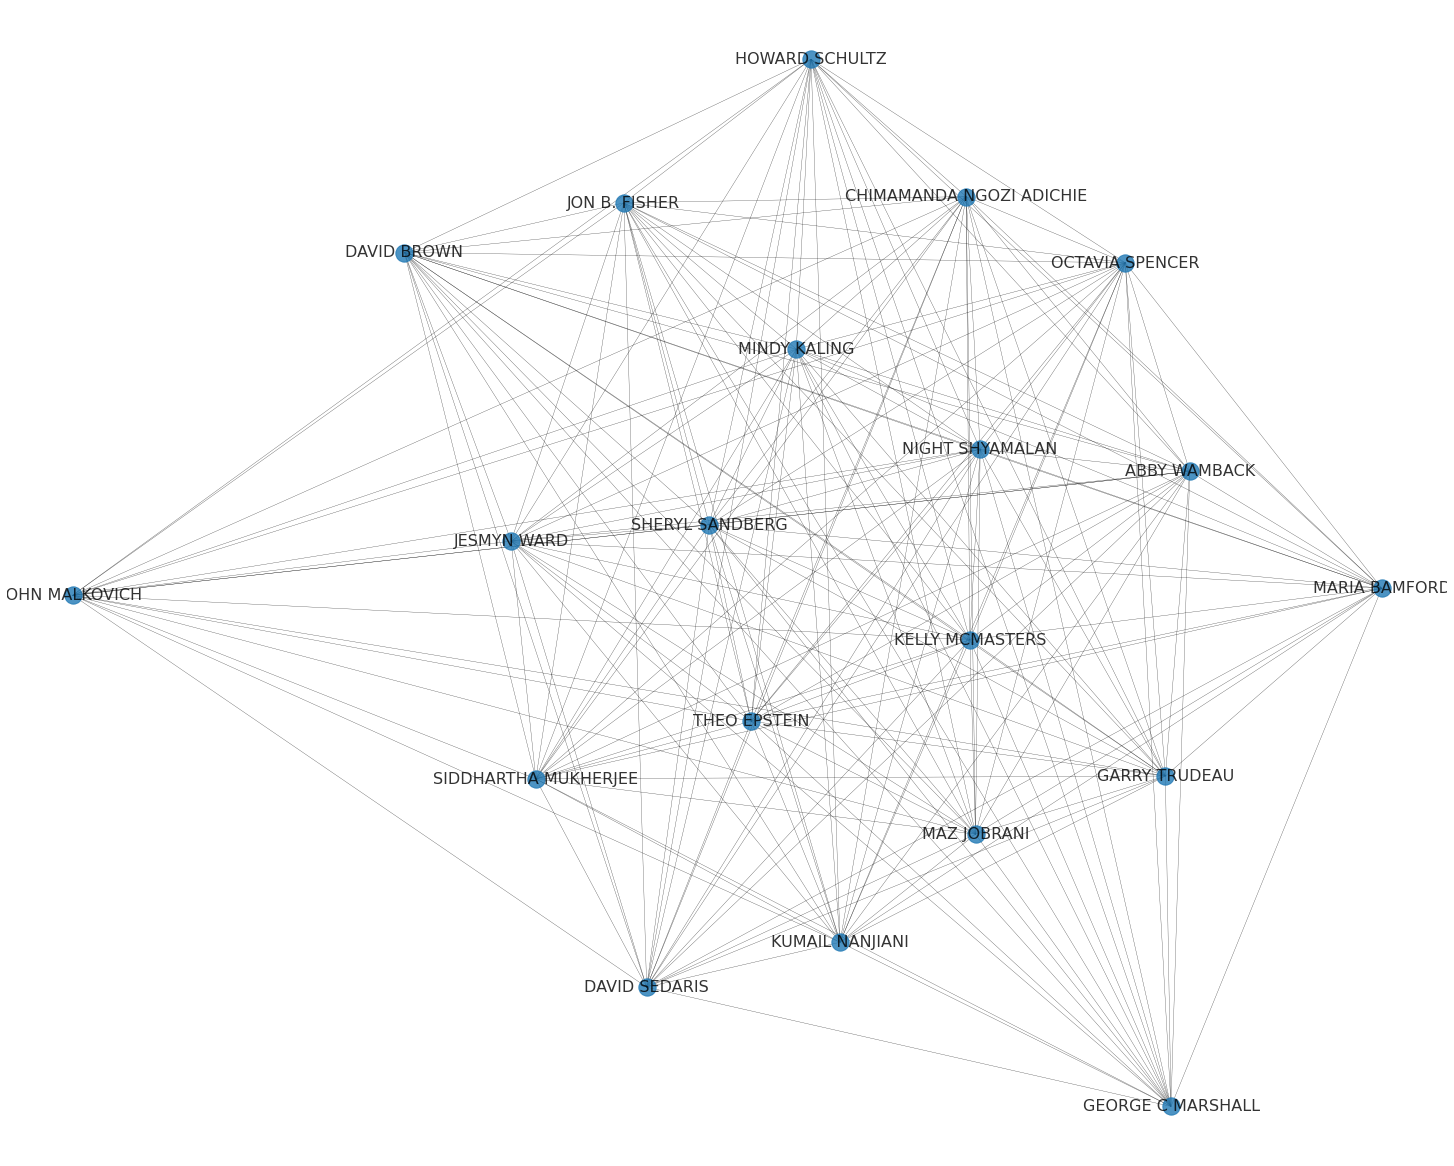

In [161]:
G = nx.Graph()

# Create nodes and edges
for node in node_list:
    G.add_node(node)
for edge, weight in speaker_word_assoc.items():
    if weight != 0:
        G.add_edge(edge[0], edge[1], weight=weight)
        
# Draw
plt.rcParams['figure.figsize'] = [20, 16]
pos = nx.spring_layout(G, iterations=50, scale=2, k=0.8)             # position of nodes
nx.draw(G, pos, with_labels=True, font_size=16,                         # node label
#             node_color=node_label, cmap='Pastel1',                          # node colorr
#             nodelist = node_list, node_size=[v*6000 for v in node_label],  # mode size
            width=.3, alpha=0.8,                                            # edge width and transparency
            )

### B. Add attributes
Give the speakers attribute (profession) for coloring.

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


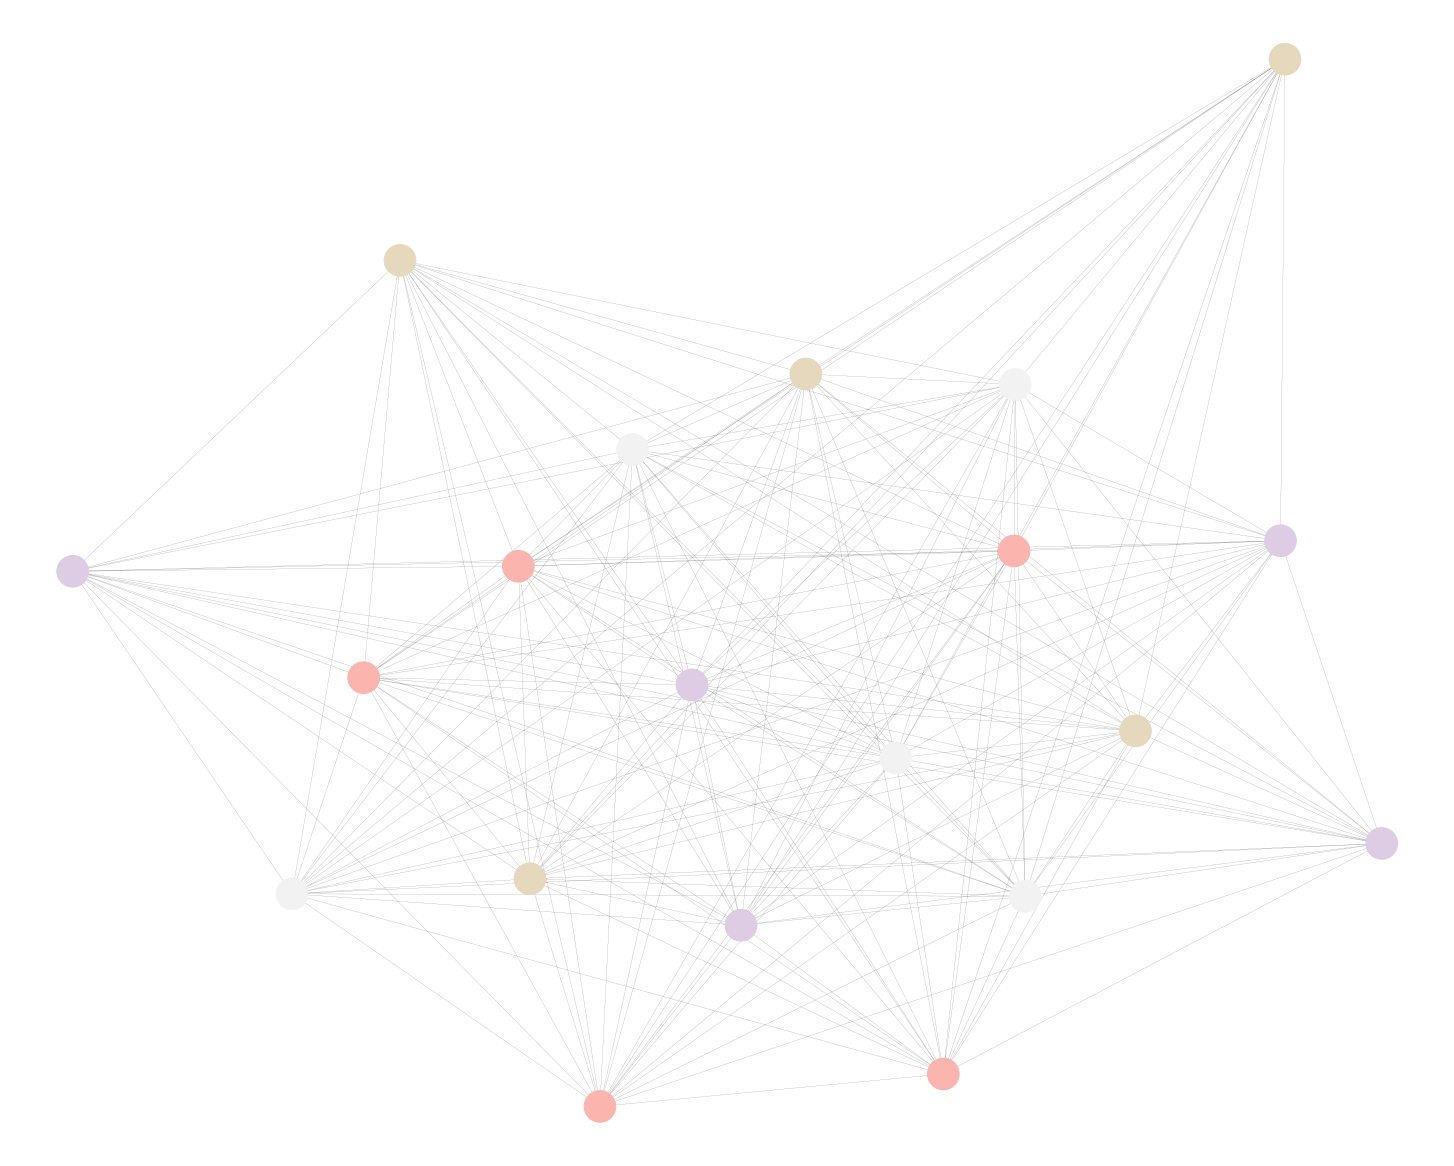

In [162]:
# Add attribute ('profession') for node color
num_professions = 4
interval = num_rows // num_professions
for n, d in list(G.nodes(data=True))[:interval]:
    G.nodes[n]['profession'] = 'Education'
for n, d in list(G.nodes(data=True))[interval:interval*2]:
    G.nodes[n]['profession'] = 'Entertainment'
for n, d in list(G.nodes(data=True))[interval*2:interval*3]:
    G.nodes[n]['profession'] = 'Tech'
for n, d in list(G.nodes(data=True))[interval*3:]:
    G.nodes[n]['profession'] = 'Publishing'

# Assign values to 'type' (if want to use 'type' as node size partition)
types = ['Education','Entertainment','Tech','Publishing']
mapping = {'Education':1, 'Entertainment':2,'Tech':3,'Publishing':4}
nodes = G.nodes()
node_label = [mapping[G.nodes[n]['profession']] for n in nodes]

# Draw
plt.rcParams['figure.figsize'] = [20, 16]
pos = nx.spring_layout(G, iterations=20, scale=2, k=0.8)             # position of nodes
nx.draw(G, pos, with_labels=False, font_size=12,                         # node label
        node_color=node_label, cmap='Pastel1',                          # node colorr
        nodelist = node_list, node_size=1000,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

# Memorize the node positions from basic plot
pos_want = pos

In [66]:
node_label

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


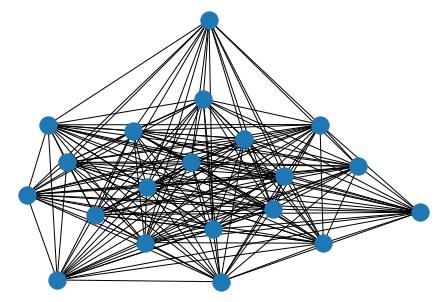

In [169]:
while not nx.is_connected(G):
    G = nx.erdos_renyi_graph(30,4.0/30)
plt.figure(figsize=(6,4));
nx.draw(G)

In [170]:
for ix,deg in G.degree():
    G.nodes[ix]['degree'] = deg
    G.nodes[ix]['parity'] = (1-deg%2)

# for ix,katz in nx.katz_centrality(G).items():
#     G.nodes[ix]['katz'] = katz

G.nodes(data=True)

NodeDataView({'SIDDHARTHA MUKHERJEE': {'profession': 'Education', 'degree': 19, 'parity': 0}, 'ABBY WAMBACK': {'profession': 'Education', 'degree': 19, 'parity': 0}, 'JON B. FISHER': {'profession': 'Education', 'degree': 19, 'parity': 0}, 'MINDY KALING': {'profession': 'Education', 'degree': 19, 'parity': 0}, 'JESMYN WARD': {'profession': 'Education', 'degree': 19, 'parity': 0}, 'NIGHT SHYAMALAN': {'profession': 'Entertainment', 'degree': 19, 'parity': 0}, 'GEORGE C MARSHALL': {'profession': 'Entertainment', 'degree': 18, 'parity': 1}, 'DAVID SEDARIS': {'profession': 'Entertainment', 'degree': 19, 'parity': 0}, 'MARIA BAMFORD': {'profession': 'Entertainment', 'degree': 18, 'parity': 1}, 'KELLY MCMASTERS': {'profession': 'Entertainment', 'degree': 19, 'parity': 0}, 'JOHN MALKOVICH': {'profession': 'Tech', 'degree': 16, 'parity': 1}, 'DAVID BROWN': {'profession': 'Tech', 'degree': 18, 'parity': 1}, 'GARRY TRUDEAU': {'profession': 'Tech', 'degree': 19, 'parity': 0}, 'MAZ JOBRANI': {'profe

In [171]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(G)
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

In [167]:
import networkx as nx
import json
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved


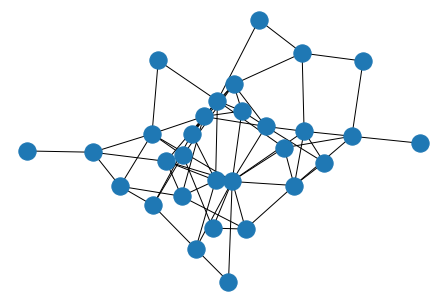

In [150]:
G = nx.erdos_renyi_graph(30,4.0/30)
while not nx.is_connected(G):
    G = nx.erdos_renyi_graph(30,4.0/30)
plt.figure(figsize=(6,4));
nx.draw(G)

In [151]:
for ix,deg in G.degree():
    G.nodes[ix]['degree'] = deg
    G.nodes[ix]['parity'] = (1-deg%2)

for ix,katz in nx.katz_centrality(G).items():
    G.nodes[ix]['katz'] = katz

G.nodes(data=True)

NodeDataView({0: {'degree': 10, 'parity': 1, 'katz': 0.280233133017297}, 1: {'degree': 7, 'parity': 0, 'katz': 0.21925857474489874}, 2: {'degree': 6, 'parity': 1, 'katz': 0.21118271643242706}, 3: {'degree': 2, 'parity': 1, 'katz': 0.13117263491136688}, 4: {'degree': 4, 'parity': 1, 'katz': 0.1630286269590175}, 5: {'degree': 3, 'parity': 0, 'katz': 0.15541091417482997}, 6: {'degree': 6, 'parity': 1, 'katz': 0.20469370451510807}, 7: {'degree': 3, 'parity': 0, 'katz': 0.15707625677145534}, 8: {'degree': 1, 'parity': 0, 'katz': 0.110802652497904}, 9: {'degree': 4, 'parity': 1, 'katz': 0.1610374939320382}, 10: {'degree': 6, 'parity': 1, 'katz': 0.20557954913381052}, 11: {'degree': 6, 'parity': 1, 'katz': 0.22157125698545627}, 12: {'degree': 1, 'parity': 0, 'katz': 0.10922496920363808}, 13: {'degree': 5, 'parity': 0, 'katz': 0.18990112391045427}, 14: {'degree': 4, 'parity': 1, 'katz': 0.17240413721097433}, 15: {'degree': 4, 'parity': 1, 'katz': 0.16651891657938536}, 16: {'degree': 5, 'parity

In [152]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(G)
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

In [173]:
%%html

<div id="d3-container-2">< /div>

<style>

.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}

< /style>

In [174]:
%%javascript
// We load the latest version of d3.js from the Web.
require.config({paths: {d3: "https://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {

    // Parameter declaration, the height and width of our viz.
    var width = 300,
        height = 300;

    // Colour scale for node colours.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    // D3 has number of layouts - refer to the documentation.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(30)
        .size([width, height]);

    // We select the < div> we created earlier and add an 
    // SVG = Scalable Vector Graphics
    var svg = d3.select("#d3-container-2").select("svg")
    if (svg.empty()) {
        svg = d3.select("#d3-container-2").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }

    
    
// We load the JSON network file.
d3.json("graph.json", function(error, graph) {
    // Within this block, the network has been loaded
    // and stored in the 'graph' object.

    // We load the nodes and links into the force-directed
    // graph and initialise the dynamics.
    force.nodes(graph.nodes)
        .links(graph.links)
        .start();

    // We create a < line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
        .data(graph.links)
        .enter().append("line")
        .attr("class", "link");

    // We create a < circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
        .data(graph.nodes)
        .enter().append("circle")
        .attr("class", "node")
        .attr("r", 5)  // radius
        .style("fill", function(d) {
            // We colour the node depending on the degree.
            return color(d.degree); 
        })
        .call(force.drag)

    // The label each node its node number from the networkx graph.
    node.append("title")
        .text(function(d) { return d.id; });

    // The label each node its node number from the networkx graph.
    node.append("title")
        .text(function(d) { return "Node: " + d.id + "\n" + "Degree: " + d.degree + "\n" + "Katz: " + d.katz;});
    
    

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed graph,
    // at each time step.
    force.on("tick", function() {
        link.attr("x1", function(d) { return d.source.x; })
            .attr("y1", function(d) { return d.source.y; })
            .attr("x2", function(d) { return d.target.x; })
            .attr("y2", function(d) { return d.target.y; });

        node.attr("cx", function(d) { return d.x; })
            .attr("cy", function(d) { return d.y; });
            


        });
    });
});

<IPython.core.display.Javascript object>